<a href="https://colab.research.google.com/github/hrkzz/Bayesian_stats_with_Pystan/blob/master/pystan2_%E9%87%8D%E5%9B%9E%E5%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#重回帰

##ライブラリ

In [0]:
#基本ライブラリ
import numpy as np
import pandas as pd

#図形描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

from matplotlib.pylab import rcParams

# 統計モデル
import statsmodels.formula.api as smf
import pystan
import pickle

##データ

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/MatsuuraKentaro/RStanBook/master/chap05/input/data-attendance-1.txt')

In [3]:
data.head()

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


A:アルバイトが好きかどうか<br>
Score:学問への興味の強さ（200点満点）<br>
Y:一年間の出席率

In [4]:
data.describe()

,A,Score,Y
count,50.000000,50.000000,50.00000
mean,0.400000,121.700000,0.26354
std,0.494872,28.136874,0.09747
min,0.000000,51.000000,0.02700
25%,0.000000,105.250000,0.19525
50%,0.000000,120.500000,0.27000
75%,1.000000,142.500000,0.34300
max,1.000000,185.000000,0.42300


###図示

####ペアプロット

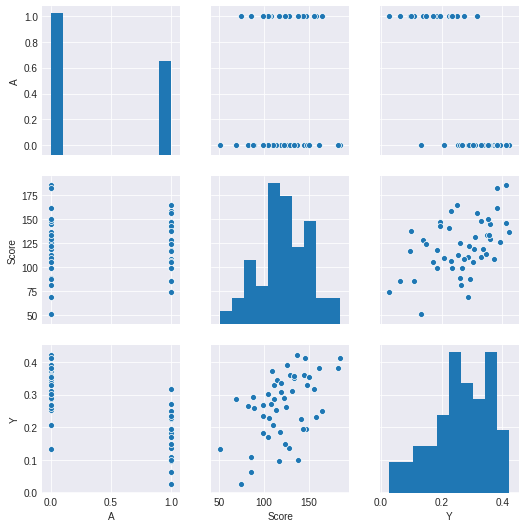

In [6]:
sns.pairplot(data)

####ヒートマップ

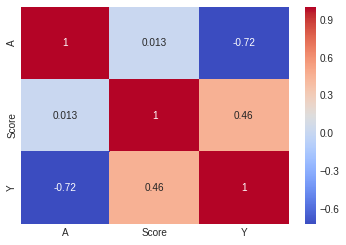

In [7]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

##モデル

$$
\begin{align}
   Y[n]& =b_1+b_2A[n]+b_3Score[n]+\varepsilon[n]&n=1..N  \\
  \varepsilon &\sim Normal(0,\sigma)&n=1..N 
\end{align}
$$

また、次のように書き直せる

$$
\begin{align}
   \mu[n]& =b_1+b_2A[n]+b_3Score[n] &n=1..N  \\
  Y[n] &\sim Normal(\mu[n],\sigma) &n=1..N 
\end{align}
$$


###Stanで実装

In [0]:
pystan2_model1 = '''
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  real<lower=0, upper=1> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*A[n] + b3*Score[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(mu[n], sigma);
}
'''

In [10]:
from google.colab import files
uploaded = files.upload()

Saving pystan2_model1.stan to pystan2_model1.stan


In [11]:
stanmodel = pystan.StanModel(file='pystan2_model1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc757e35b5293ba1890ed1ca17a86368 NOW.


In [0]:
data_stan = dict(N=data.shape[0], A=data.A, Score=data.Score/200, Y=data.Y)
fit = stanmodel.sampling(data=data_stan, seed=1234, n_jobs=-1)

##推定結果の解釈

In [16]:
print(fit) 

Inference for Stan model: anon_model_bc757e35b5293ba1890ed1ca17a86368.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  8.0e-4   0.03   0.06    0.1   0.12   0.14   0.19   1708    1.0
b2          -0.14  3.0e-4   0.02  -0.17  -0.15  -0.14  -0.13  -0.11   2560    1.0
b3           0.33  1.2e-3   0.05   0.22   0.29   0.33   0.36   0.43   1801    1.0
sigma        0.05  1.1e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06   2524    1.0
mu[1]        0.23  3.9e-4   0.02    0.2   0.22   0.23   0.25   0.27   1773    1.0
mu[2]        0.22  2.5e-4   0.01   0.19   0.21   0.22   0.22   0.24   2715    1.0
mu[3]        0.33  1.6e-4 9.3e-3   0.31   0.32   0.33   0.33   0.34   3349    1.0
mu[4]        0.12  2.9e-4   0.01   0.09   0.11   0.12   0.13   0.15   2658    1.0
mu[5]        0.24  3.0e-4   0.02   0.21   0.23   0.24   0.25   0.27   251

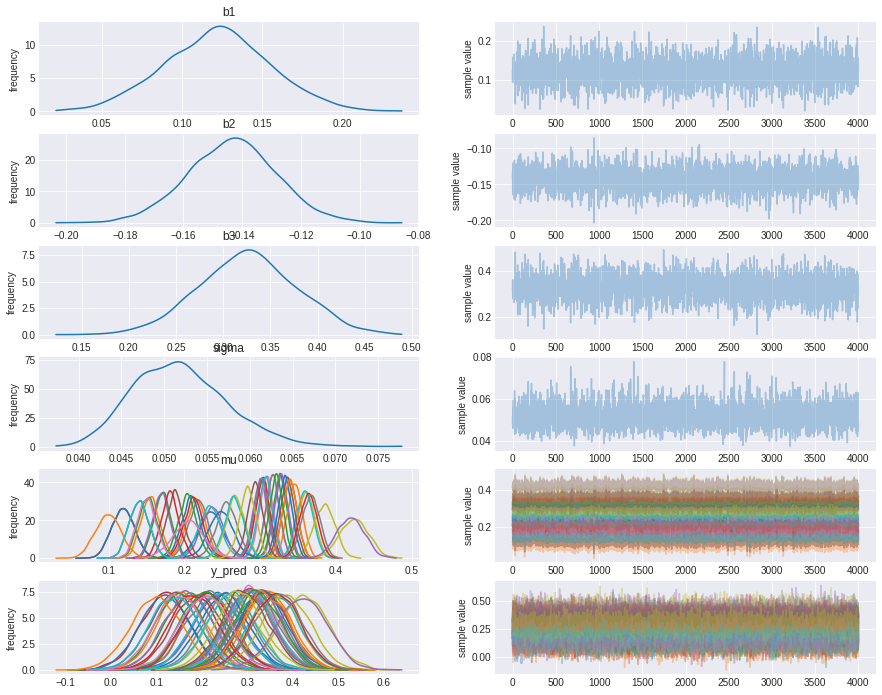

In [0]:
rcParams['figure.figsize'] = 15, 12
fit.traceplot()
plt.show()

結果により、以下のように書くことが出来る
$$
\begin{align}
  \mu[n]&=0.12-0.14A[n]+0.33Score[n]/200&n=1..N\\
  Y[n] &\sim Normal(\mu[n],0.05) &n=1..N
\end{align}
$$
<br>
・アルバイトが好きでScoreがゼロの場合、出席率の事後平均がマイナスと算出されるが、この与えられたデータの範囲の外側を予測することを外挿という。算出結果は注意してみる必要がある。<br>
・b3のベイズ信頼区間は0.22～0.43となっており、ゼロをまたいでいないので、Scoreが上がれば、出席率が上がると読み取って良い。これをBayesian p-valueと呼ぶ場合がある。

##図によるモデルチェック

###プロット

In [0]:
ms = fit.extract()

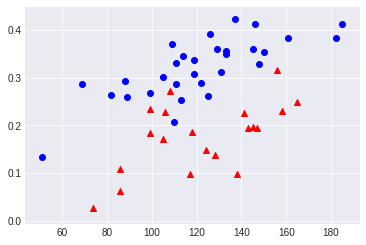

In [180]:
plt.scatter(x=data.Score[data.A==1],y=data.Y[data.A==1], c='red', marker='^')
plt.scatter(x=data.Score[data.A==0],y=data.Y[data.A==0], c='blue', marker='o')

In [0]:
y_pred10 = pd.DataFrame(ms['y_pred']).apply(lambda x: np.percentile(x, 10), axis=0)
y_pred50 = pd.DataFrame(ms['y_pred']).apply(lambda x: np.percentile(x, 50), axis=0)
y_pred90 = pd.DataFrame(ms['y_pred']).apply(lambda x: np.percentile(x, 90), axis=0)
data_plot = pd.DataFrame(dict(y_pred10=y_pred10, y_pred50=y_pred50, y_pred90=y_pred90, A=data.A, Score=data.Score))

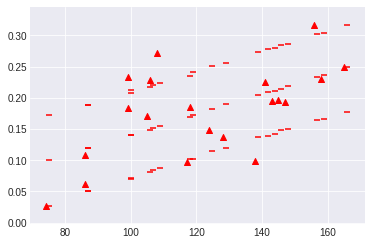

In [178]:
plt.scatter(x=data.Score[data.A==1],y=data.Y[data.A==1], c='red', marker='^')
plt.scatter(x=data_plot.Score[data_plot.A==1],y=data_plot.y_pred50[data_plot.A==1], c='red', marker=1)
plt.scatter(x=data_plot.Score[data_plot.A==1],y=data_plot.y_pred10[data_plot.A==1], c='red', marker=1)
plt.scatter(x=data_plot.Score[data_plot.A==1],y=data_plot.y_pred90[data_plot.A==1], c='red', marker=1)

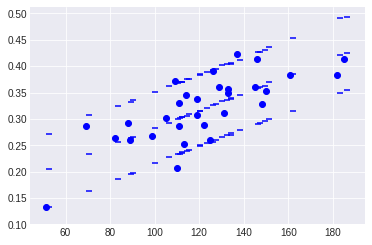

In [179]:
plt.scatter(x=data.Score[data.A==0],y=data.Y[data.A==0], c='blue', marker='o')
plt.scatter(x=data_plot.Score[data_plot.A==0],y=data_plot.y_pred10[data_plot.A==0], c='blue', marker=1)
plt.scatter(x=data_plot.Score[data_plot.A==0],y=data_plot.y_pred50[data_plot.A==0], c='blue', marker=1)
plt.scatter(x=data_plot.Score[data_plot.A==0],y=data_plot.y_pred90[data_plot.A==0], c='blue', marker=1)

多くの実測値が予測された中央値の付近にあり、また、実測値の多くが予測値の80パーセンタイルの中にあるので、モデルは問題ないと解釈できる。

###実測値と予測値のプロット

In [0]:
observed = data.Y
predicted = pd.DataFrame(ms['y_pred']).apply(lambda x: np.percentile(x, 50), axis=0)

#For y=x
xx = np.linspace(0,0.5,100)
yy = xx

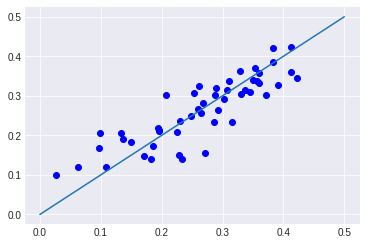

In [195]:
plt.scatter(x=observed,y=predicted, c='blue', marker='o')
plt.plot(xx,yy)

###推定されたノイズの分布

In [0]:
noise_mu = data.Y - ms['mu'].mean(axis=0) 

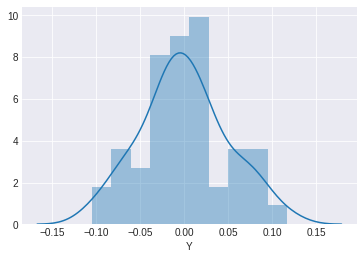

In [202]:
sns.distplot(noise_mu, bins=10)

In [0]:
noise_median = data.Y - predicted

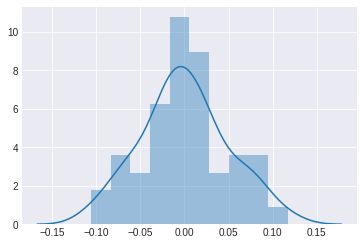

In [204]:
sns.distplot(noise_median, bins=10)